# Meal Delivery Optimization
*Developed for [Thanksgiving for Paso Robles](http://www.thanksgivingforpasorobles.com/)*

# Problem Statement
A team needs to make deliveries to a set of addresses in a semi-optimized manner. The inputs are a [list of addresses to deliver to] and the number of drivers available. Our goal is to print a list of delivery addresses for each driver in an automated way so that if the address list or number of drivers available changes we can quickly re-generate the list.

In this analysis we minimize the average time traveled by each driver while keeping the number of stops per driver roughly equal.


Inputs:

In [1]:
# 1. Enter the number of driveres:
n_drivers = 12

# 2. Enter the distance calculation method. Options
#    - COORDINATES: Uses simple distance between lat/lng coordinates. Less accurate but quick.
#    - GOOGLE: Uses the Google Distance Matrix API (more accurate but ~20 min for 
#              100 stops + fees).
DISTANCE_METHOD='COORDINATES'

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-ticks')

In [3]:
%load_ext watermark
%watermark -iv

numpy       1.14.2
pandas      0.23.4
matplotlib  3.0.0



In [4]:
# Google Maps API authentication
file  = open('GoogleMapsAPIKey.txt', 'r')
apiKey = file.read()

## 1. Load Data
We load the data required, which is a list of addresses needing deliveries. This list includes latitude and longitude of each address. Use [this script **ADD**]() to get the latitude and longitude if you don't already have them.

Note that the first address in the list needs to be the home base where deliveries originate.

In [5]:
df = pd.read_excel('Meal Deliveries (coordinates).xlsx')

# 3. Clustering
We use the sklearn kmeans algorithm to cluster the locations into a group for each driver. Note that this does not gurantee an equal number of locations in each cluster, and may produce clusters with only one outlier locaiton. It may be necessary to manually adjust the number of clusters to arrive at an appropriate route for each driver.

In [6]:
X = df.as_matrix(columns=['lat','lng'])
X

/Users/matthewkudija/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[  35.6229385, -120.6707667],
       [  35.646331 , -120.6755737],
       [  35.620226 , -120.660585 ],
       [  35.6137137, -120.6775696],
       [  35.6260559, -120.6638703],
       [  35.6110299, -120.6583439],
       [  35.6070867, -120.6481666],
       [  35.6160501, -120.6657123],
       [  35.6278298, -120.6765845],
       [  35.6072435, -120.6465714],
       [  35.6450182, -120.6926439],
       [  35.6168486, -120.6752143],
       [  35.608402 , -120.647897 ],
       [  35.6283834, -120.6824021],
       [  35.6137137, -120.6775696],
       [  35.6422097, -120.6871413],
       [  35.6450182, -120.6926439],
       [  35.6450182, -120.6926439],
       [  35.6450182, -120.6926439],
       [  35.6198394, -120.6647688],
       [  35.606651 , -120.648149 ],
       [  35.6450182, -120.6926439],
       [  35.612539 , -120.67406  ],
       [  35.6337079, -120.6940004],
       [  35.6436415, -120.6912065],
       [  35.6450182, -120.6926439],
       [  35.607081 , -120.6492226],
 

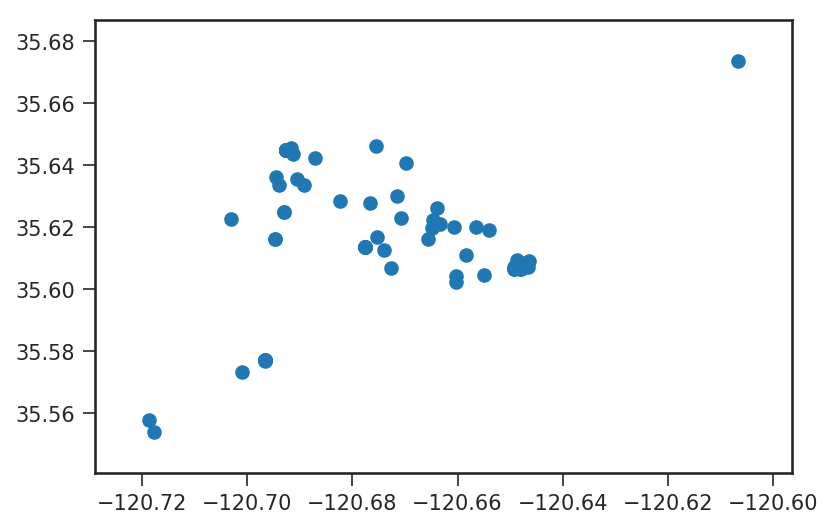

In [7]:
# plt.scatter(X[:, 0], X[:, 1])
plt.scatter(df['lng'], df['lat'])

In [8]:
# # create distance matrix (from coordinates)
# D = np.zeros(shape=(df.shape[0],df.shape[0]))

# for row in range(df.shape[0]): 
#     origin = df.loc[df.index[row],'Address']
#     orig_lat = df.loc[df.index[row],'lat']
#     orig_lng = df.loc[df.index[row],'lng']
#     for col in range(df.shape[0]):
#         destination = df.loc[df.index[col],'Address']
#         dest_lat = df.loc[df.index[col],'lat']
#         dest_lng = df.loc[df.index[col],'lng']
#         if origin!=destination:
#             distance = math.sqrt((dest_lat-orig_lat)**2 + (dest_lng-orig_lng)**2) * 1000              
#             D[row,col] = distance
# D

In [9]:
def get_drive_time(apiKey, origin, destination):
    """
    Returns the driving time between using the Google Maps Distance Matrix API. 
    API: https://developers.google.com/maps/documentation/distance-matrix/start

    
    # INPUT -------------------------------------------------------------------
    apiKey                  [str]
    origin                  [str]
    destination             [str]

    # RETURN ------------------------------------------------------------------
    drive_tim               [float] (minutes)
    """
    import requests
    url = ('https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins={}&destinations={}&key={}'
           .format(origin.replace(' ','+'),
                   destination.replace(' ','+'),
                   apiKey
                  )
          )
    try:
        response = requests.get(url)
        resp_json_payload = response.json()
        drive_time = resp_json_payload['rows'][0]['elements'][0]['duration']['value']/60
    except:
        print('ERROR: {}, {}'.format(origin, destination))
        drive_time = 0
    return drive_time
           
# test...
# origin = '3272 Ainwick Road, Columbus, OH'
# destination = '375 N Front St. Columbus, OH'
# drive_time = get_drive_time(apiKey, origin, destination)
# print(drive_time)

In [10]:
# create distance matrix (from Google Distance Matrix API)
# https://developers.google.com/maps/documentation/distance-matrix/start

D = np.zeros(shape=(df.shape[0],df.shape[0]))

for row in range(df.shape[0]): 
    origin = df.loc[df.index[row],'Address']
    orig_lat = df.loc[df.index[row],'lat']
    orig_lng = df.loc[df.index[row],'lng']
    for col in range(df.shape[0]):
        destination = df.loc[df.index[col],'Address']
        dest_lat = df.loc[df.index[col],'lat']
        dest_lng = df.loc[df.index[col],'lng']
        if origin!=destination:
            if DISTANCE_METHOD=='GOOGLE':
                distance = get_drive_time(apiKey, origin, destination)
            elif DISTANCE_METHOD=='COORDINATES':
                distance = math.sqrt((dest_lat-orig_lat)**2 + (dest_lng-orig_lng)**2) * 1000              
            D[row,col] = distance
D

array([[ 0.        , 23.88129614, 10.53682453, ..., 22.3196809 ,
        26.89467975, 11.46195374],
       [23.88129614,  0.        , 30.10202905, ..., 27.65298263,
        47.55219518, 32.67830895],
       [10.53682453, 30.10202905,  0.        , ..., 32.74818021,
        17.61031164, 18.19029105],
       ...,
       [22.3196809 , 27.65298263, 32.74818021, ...,  0.        ,
        47.28770444, 19.03929718],
       [26.89467975, 47.55219518, 17.61031164, ..., 47.28770444,
         0.        , 29.07810591],
       [11.46195374, 32.67830895, 18.19029105, ..., 19.03929718,
        29.07810591,  0.        ]])

In [11]:
# locs = [0,24]
# origin = df.loc[df.index[locs[0]],'Address']
# destination = df.loc[df.index[locs[1]],'Address']
# dist = D[locs[0],locs[1]]
# print('Distance between:\n{}\n{}\n{}'.format(origin,destination,dist))

In [12]:
def get_driver_distance(locations):
    # location 0 is home base, so prepend and append list
    locations.insert(0, 0)
    locations.append(0)
    driver_distance = 0
    for i in range(len(locations)-1):
        distance = D[locations[i],locations[i+1]]
        driver_distance += distance
    return driver_distance

def switch_two(all_locs):
    i = random.sample(range(1,len(all_locs)), 2)
#     print(i)
    all_locs_new = all_locs[:]
    all_locs_new[i[0]] = all_locs[i[1]]
    all_locs_new[i[1]] = all_locs[i[0]]
    return all_locs_new

def divide_list(my_list, n_result):
    avg = len(my_list) / float(n_result)
    my_list_divided = []
    last = 0.0
    while last < len(my_list):
        my_list_divided.append(my_list[int(last):int(last + avg)])
        last += avg
    return my_list_divided

def get_total_distance(driver_routes):
    total_distance = 0
    driver_distances = []
    for i in range(len(driver_routes)):
        driver_distance = get_driver_distance(driver_routes[i])
        driver_distances.append(driver_distance)
        total_distance+=driver_distance
    return total_distance, driver_distances

def get_avg_distance(driver_routes):
    driver_distances = []
    for i in range(len(driver_routes)):
        driver_distance = get_driver_distance(driver_routes[i])
        driver_distances.append(driver_distance)
    avg_distance = np.mean(driver_distances)
    return avg_distance, driver_distances

260.9888544166907


Text(0.5, 0, '# Iterations')

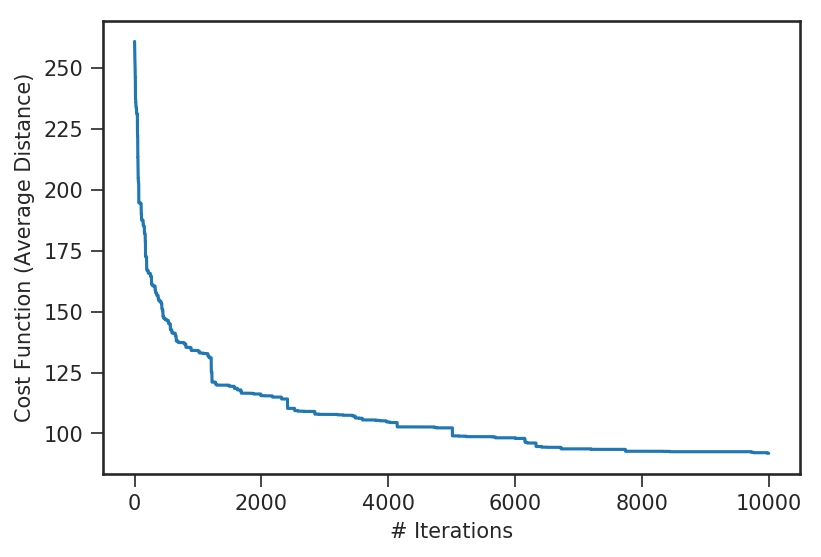

In [13]:
all_locs = list(range(df.shape[0]))[1:]
driver_routes = divide_list(my_list=all_locs, n_result=n_drivers)
avg_difference, driver_distances = get_avg_distance(driver_routes)
print(avg_difference)

distances = []
for i in range(10000):
#     all_locs_new = all_locs[:]
    all_locs_new = switch_two(all_locs)
    driver_routes_new = divide_list(my_list=all_locs_new, n_result=n_drivers)
    avg_difference_new, driver_distances = get_avg_distance(driver_routes_new)

    if avg_difference_new < avg_difference:
        all_locs = all_locs_new[:]
        avg_difference = avg_difference_new
        distances.append(avg_difference)
    else:
        distances.append(avg_difference)

plt.plot(range(len(distances)),distances)
plt.ylabel('Cost Function (Average Distance)')
plt.xlabel('# Iterations')

In [14]:
driver_routes_new

[[0, 1, 45, 74, 51, 78, 5, 0],
 [0, 31, 41, 62, 10, 58, 18, 63, 0],
 [0, 29, 52, 16, 17, 12, 24, 0],
 [0, 37, 21, 50, 66, 23, 77, 59, 0],
 [0, 34, 47, 67, 70, 60, 55, 0],
 [0, 42, 72, 36, 27, 73, 76, 39, 0],
 [0, 79, 56, 3, 57, 38, 14, 53, 0],
 [0, 54, 75, 69, 40, 30, 19, 0],
 [0, 26, 6, 64, 20, 7, 22, 11, 0],
 [0, 15, 61, 43, 35, 32, 65, 0],
 [0, 13, 71, 49, 4, 68, 8, 33, 0],
 [0, 28, 48, 46, 9, 25, 2, 44, 0]]

In [15]:
driver_distances

[204.64069433523474,
 62.165103777920415,
 175.9386732913723,
 73.84305507887024,
 106.96568741243846,
 190.58444452531822,
 57.63243969425821,
 61.74084652348397,
 69.38647167107722,
 63.36597959532197,
 87.99055843397626,
 140.81081004096612]

In [16]:
sum(driver_distances)

1295.064764380238

In [17]:
np.std(driver_distances)

52.97856239857731

In [18]:
print(max(driver_distances)-min(driver_distances))

147.00825464097653


# Print Driver Lists

In [19]:
# write driver-stop to dataframe
df['Driver-Stop'] = ''
for driver in range(len(driver_routes_new)):
    for stop in range(len(driver_routes_new[driver])):
        row = driver_routes_new[driver][stop]
        if row>0:
            if driver+1<10:
                df.loc[df.index[row],'Driver-Stop'] = '0{}-{}'.format(driver+1,stop)
            else:
                df.loc[df.index[row],'Driver-Stop'] = '{}-{}'.format(driver+1,stop)        

In [20]:
# save Excel
cols = ['Driver-Stop','Qty','Address','Apt','Last Name','First Name','Phone',
        'Note1','Note2', 'Note3', 'Confirmed']
df = df[cols].sort_values('Driver-Stop')
writer = pd.ExcelWriter('Delivery List.xlsx')
df.to_excel(writer, sheet_name='Deliveries', index=False)
writer.save()
print('Done.')

Done.


In [21]:
# # creat google maps URL for each driver
# df['Driver-Stop'] = ''
# for driver in range(len(driver_routes_new)):
#     print('\n\nDRIVER {}'.format(driver+1))
#     addresses = []
#     for stop in range(len(driver_routes_new[driver])):
#         row = driver_routes_new[driver][stop]
#         address = df.loc[df.index[row],'Address']
#         apt = df.loc[df.index[row],'Apt']
#         qty = df.loc[df.index[row],'Qty']
#         addresses.append(address)
#         if row>0:
#             if driver+1<n_drivers+1:
#                 if pd.isnull(apt):
#                     print('\tQty {}: {}'.format(qty,address))
#                 else:
#                     print('\tQty {}: {} (#{})'.format(qty,address,apt))
#     url = 'https://www.google.com/maps/dir'
#     for item in addresses:
#         url_add = '/{}'.format(item.replace(' ','+'))
#         url = url+url_add
#     print('Directions: '+url)

In [22]:
# create summary for each driver
df['Name'] = df['First Name']+' '+df['Last Name']
df['Note1'] = df['Note1'].fillna('')
df['Phone'] = df['Phone'].fillna('            ')

file  = open('Delivery List.txt', 'w')
file.write('Driver Summary')
df['Driver-Stop'] = ''
for driver in range(len(driver_routes_new)):
    file.write('\n\nDRIVER {}'.format(driver+1))
    addresses = []
    for stop in range(len(driver_routes_new[driver])):
        row = driver_routes_new[driver][stop]
        address = df.loc[df.index[row],'Address']
        apt = df.loc[df.index[row],'Apt']
        qty = df.loc[df.index[row],'Qty']
        phone = df.loc[df.index[row],'Phone']
        name = df.loc[df.index[row],'Name']
        note = df.loc[df.index[row],'Note1']
        addresses.append(address)
        if row>0:
            if driver+1<n_drivers+1:
                if pd.isnull(apt):
                    file.write('\n  - Qty {}: {}'.format(qty,address))
                    # file.write('\n({}) {:<14}{:<25}{}\t{}'.format(qty,phone,name,address,note))
                else:
                    file.write('\n  - Qty {}: {} (#{})'.format(qty,address,apt))
                    # file.write('\n({}) {:<14}{:<25}{} (#{})\t{}'.format(qty,phone,name,address,apt,note))
    url = 'https://www.google.com/maps/dir'
    for item in addresses:
        url_add = '/{}'.format(item.replace(' ','+'))
        url = url+url_add
    file.write('\nDirections: {}'.format(url))
file.close()
print('Done.')

Done.
